In [ ]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import lag_plot
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
train = pd.read_csv("dengue_features_train.csv", index_col = [0, 1, 2])

In [ ]:
labels = pd.read_csv("dengue_labels_train.csv", index_col = [0, 1, 2])

In [ ]:
train["total_cases"] = labels["total_cases"]

In [ ]:
train.head()

week_start_date   ndvi_ne  ...  station_precip_mm  total_cases
city year weekofyear                            ...                                
sj   1990 18              1990-04-30  0.122600  ...               16.0            4
          19              1990-05-07  0.169900  ...                8.6            5
          20              1990-05-14  0.032250  ...               41.4            4
          21              1990-05-21  0.128633  ...                4.0            3
          22              1990-05-28  0.196200  ...                5.8            6

[5 rows x 22 columns]

In [ ]:
sj_train = train.loc["sj"]
iq_train = train.loc["iq"]

In [ ]:
test = pd.read_csv("dengue_features_test.csv", index_col = [0])

In [ ]:
len(test)

416

In [ ]:
sj_test = test.loc["sj"]
iq_test = test.loc["iq"]

In [ ]:
sj_train.tail()

week_start_date  ndvi_ne  ...  station_precip_mm  total_cases
year weekofyear                           ...                                
2008 13              2008-03-25  0.07785  ...                1.8            4
     14              2008-04-01 -0.03800  ...                0.5            3
     15              2008-04-08 -0.15520  ...               30.7            1
     16              2008-04-15  0.00180  ...               11.2            3
     17              2008-04-22 -0.03700  ...                0.3            5

[5 rows x 22 columns]

In [ ]:
sj_test.head()

,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
city,,,,,,,,,,,,,,,,,,,,,,,
sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


In [ ]:
iq_train.head()

week_start_date   ndvi_ne  ...  station_precip_mm  total_cases
year weekofyear                            ...                                
2000 26              2000-07-01  0.192886  ...                3.0            0
     27              2000-07-08  0.216833  ...               55.6            0
     28              2000-07-15  0.176757  ...               38.1            0
     29              2000-07-22  0.227729  ...               30.0            0
     30              2000-07-29  0.328643  ...                4.0            0

[5 rows x 22 columns]

In [ ]:
iq_test.head()

,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
city,,,,,,,,,,,,,,,,,,,,,,,
iq,2010,26,2010-07-02,0.183783,0.142500,0.225129,0.150214,82.29,297.648571,299.214286,296.118571,307.9,293.7,34.11,92.581429,82.29,17.654286,9.428571,27.440,10.760,33.8,21.5,11.2
iq,2010,27,2010-07-09,0.291657,0.272267,0.330700,0.320914,25.30,298.224286,299.464286,294.831429,307.7,292.2,9.10,83.885714,25.30,16.320000,10.157143,27.025,9.625,33.0,21.2,8.9
iq,2010,28,2010-07-16,0.208543,0.366457,0.212629,0.255514,62.14,297.955714,298.964286,296.417143,306.4,292.5,61.09,92.057143,62.14,18.030000,9.557143,26.950,10.350,33.4,21.6,22.6
iq,2010,29,2010-07-23,0.089286,0.063214,0.122057,0.081957,47.80,295.715714,296.642857,293.638571,306.4,289.3,19.60,88.970000,47.80,15.394286,7.828571,26.900,9.700,33.3,14.2,4.8
iq,2010,30,2010-07-30,0.306100,0.327683,0.250086,0.267914,56.30,298.502857,300.000000,293.892857,308.1,290.5,18.93,78.610000,56.30,15.468571,11.771429,27.050,11.850,33.5,16.9,3.0


Test for Stationarity: 
Look at plots for visible trends in series

Then perform statistical tests to confirm stationarity

"Augmented Dickey - Fuller Test"

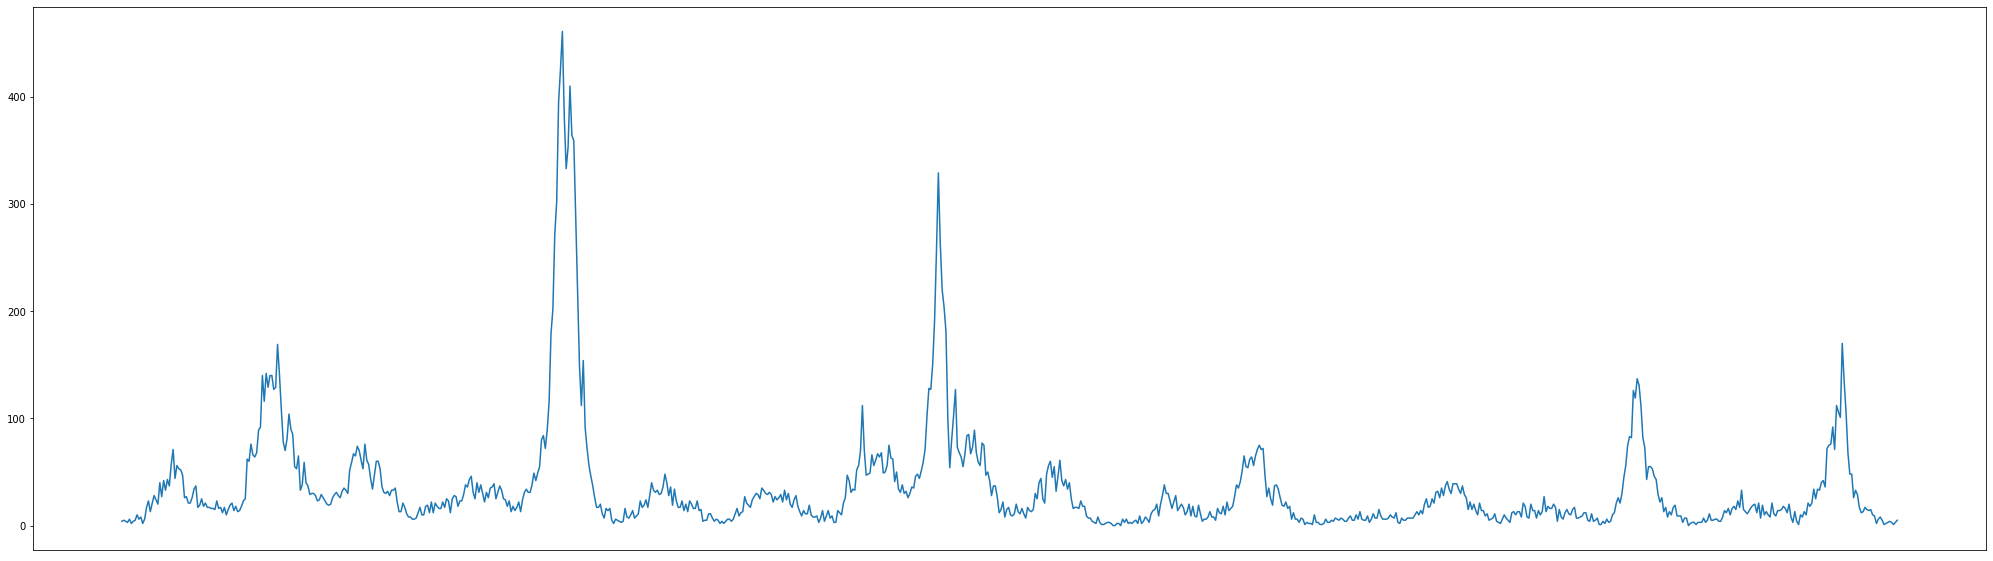

In [ ]:
plt.figure(figsize=(35, 10))
plt.plot(sj_train["week_start_date"], sj_train["total_cases"])
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(1, month=1, day=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.show()
# no obvious trends seen in plot

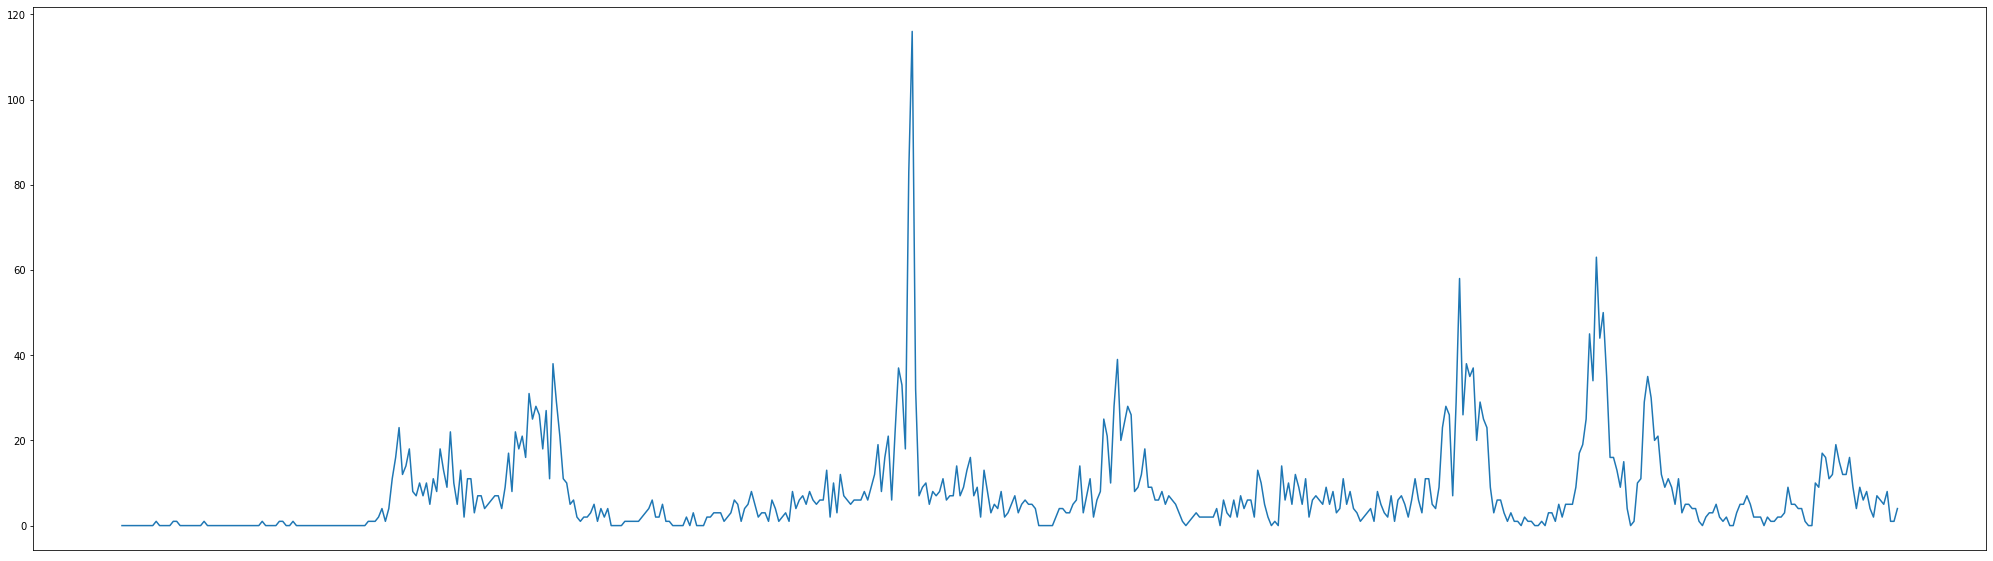

In [ ]:
plt.figure(figsize=(35, 10))
plt.plot(iq_train["week_start_date"], iq_train["total_cases"])
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(1, month=1, day=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.show()
# no obvious trends seen in plot. But the initial values are zero continuosly 

In [ ]:
adfuller(sj_train["total_cases"])
# p-value is very low. So the series is stationary

(-6.650077901931195,
 5.1473186737591e-09,
 9,
 926,
 {'1%': -3.4374315551464734,
  '10%': -2.568434614986309,
  '5%': -2.8646662624723502},
 7311.570011083799)

In [ ]:
adfuller(iq_train["total_cases"])
# p-value is very low. So the series is stationary

(-6.085428681900057,
 1.0672522948401663e-07,
 4,
 515,
 {'1%': -3.4431115411022146,
  '10%': -2.5697677754736543,
  '5%': -2.8671684899522023},
 3384.7747959569506)

Both the cities have stationery spread over time.

So we can employ TSA models to forecast spread

Plot ACF and PACF functions to get insights

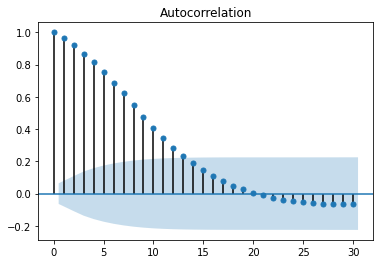

In [ ]:
plot_acf(sj_train["total_cases"])
plt.show()
# definitely not MA model

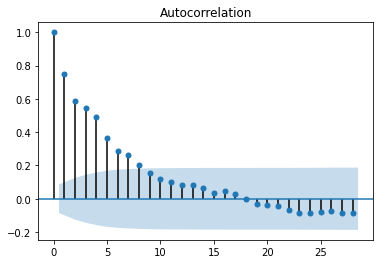

In [ ]:
plot_acf(iq_train["total_cases"])
plt.show()
# probably not MA

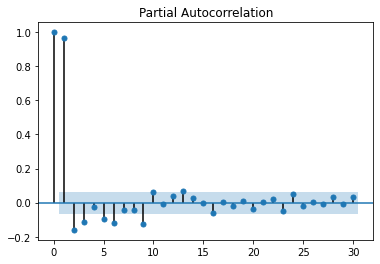

In [ ]:
plot_pacf(sj_train["total_cases"])
plt.show()
# good signs of AR(1)

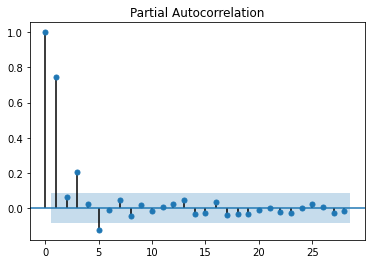

In [ ]:
plot_pacf(iq_train["total_cases"])
plt.show()
# good signs of AR(1)

In [ ]:
print(list(iq_train["total_cases"].head(75)))
# for first seventy five weeks are almost no new cases found

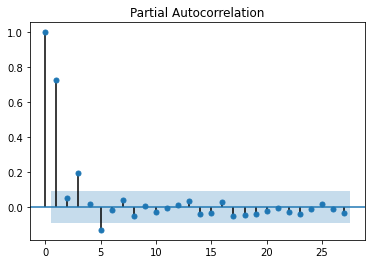

In [ ]:
plot_pacf(iq_train["total_cases"][75:len(iq_train)])
plt.show()

By the looks of the ACF and PACF plots, we can model the data with AR(1) process and get good results

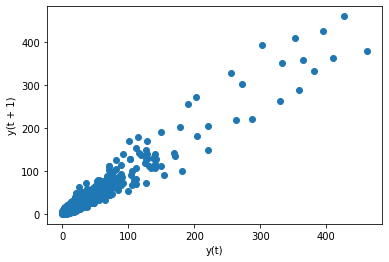

In [ ]:
lag_plot(sj_train["total_cases"])
# almost y = mx line

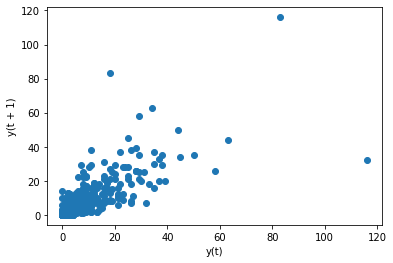

In [ ]:
lag_plot(iq_train["total_cases"])
# not quite the linear scatterplot

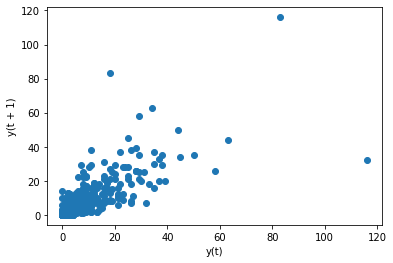

In [ ]:
# ignoring initial continious weeks with 0 cases 
lag_plot(iq_train["total_cases"][75:len(iq_train)])

Creating AR(1) model for San Juan and making predictions

In [ ]:
sj_model = AR(sj_train["total_cases"])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
sj_ar_fit = sj_model.fit(maxlag = 2, trend = "nc")

In [ ]:
print('Coefficients: %s' % sj_ar_fit.params)

Coefficients: L1.total_cases    1.122050
L2.total_cases   -0.150082
dtype: float64


In [ ]:
sj_preds = sj_ar_fit.predict(start=len(sj_train), end=len(sj_train)+len(sj_test)-1, dynamic=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [1]:
#sj_preds

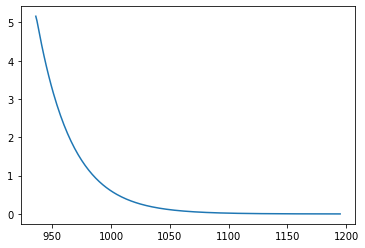

In [ ]:
plt.plot(sj_preds)
plt.show()

Seasonality is not accounted. So predictions are very bad

Creating AR(1) for Iquitos and making predictions

In [ ]:
iq_model = AR(iq_train["total_cases"])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
iq_ar_fit = iq_model.fit(maxlag = 1)

In [ ]:
print('Coefficients: %s' % iq_ar_fit.params)

Coefficients: const             1.924950
L1.total_cases    0.746807
dtype: float64


In [ ]:
iq_preds = iq_ar_fit.predict(start=len(iq_train), end=len(iq_train)+len(iq_test)-1, dynamic=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


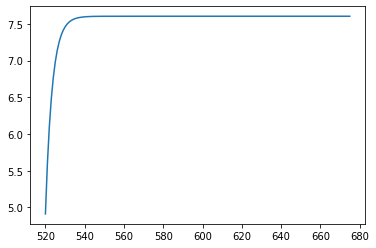

In [ ]:
plt.plot(iq_preds)
plt.show()

In [2]:
#submission = pd.read_csv("submission_format.csv")

In [3]:
#submission

In [ ]:
#total_preds = sj_preds.append(iq_preds)

In [ ]:
#submission["total_cases"] = total_preds

In [4]:
#submission

Seasonality in total_cases should be considered.
Plotting periodogram to understand seasonalit in data better

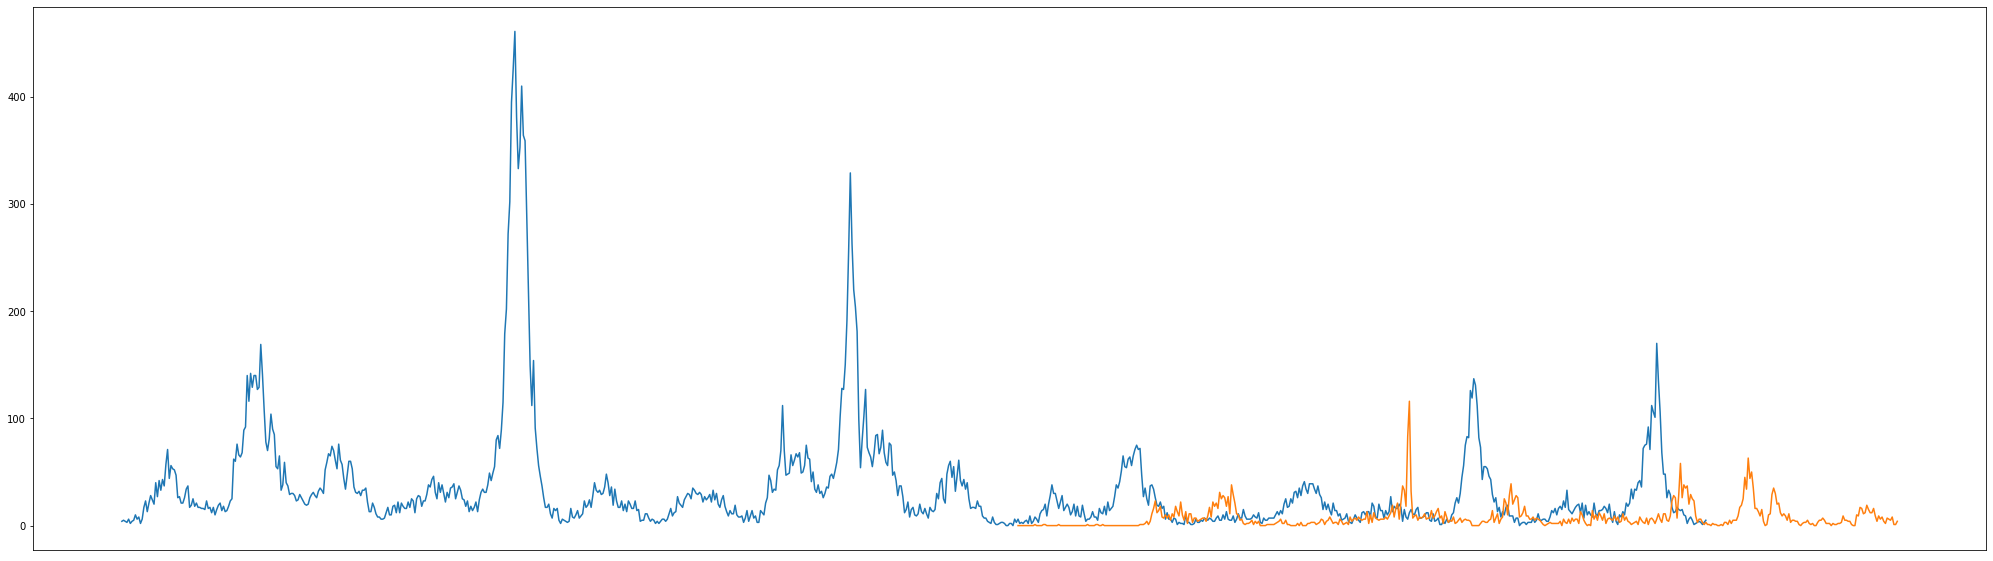

In [ ]:
plt.figure(figsize=(35, 10))
plt.plot(sj_train["week_start_date"], sj_train["total_cases"])
plt.plot(iq_train["week_start_date"], iq_train["total_cases"])
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(1, month=1, day=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.show()

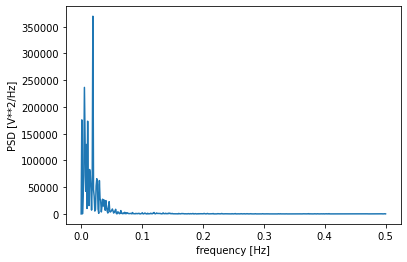

In [ ]:
sj_f, sj_Pxx_den = signal.periodogram(sj_train["total_cases"])
plt.plot(sj_f, sj_Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

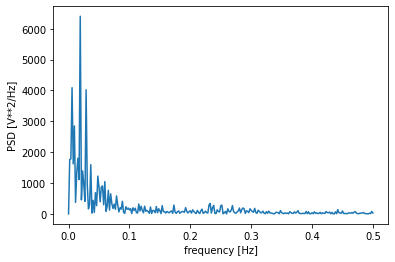

In [ ]:
iq_f, iq_Pxx_den = signal.periodogram(iq_train["total_cases"])
plt.plot(iq_f, iq_Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

Visual inspection is unyielding. But, Since the spread of dengue is reported yearly, considering a year as a seasonality is a good approximation. Plotting to see effect of 52 weeks as a seasonality parameter

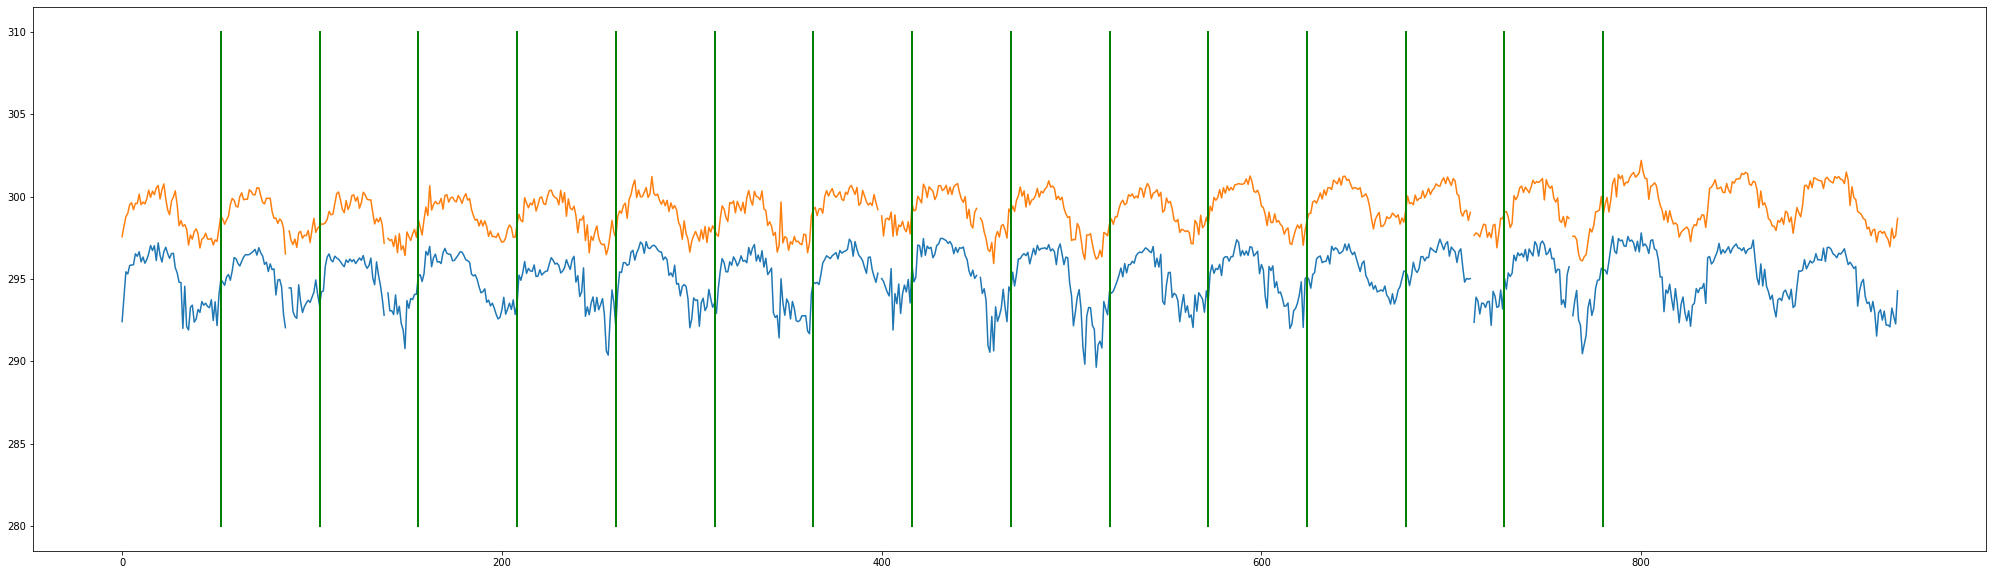

In [ ]:
plt.figure(figsize=(35, 10))
plt.plot(range(len(sj_train["week_start_date"])), sj_train["reanalysis_dew_point_temp_k"])
plt.plot(range(len(sj_train["week_start_date"])), sj_train["reanalysis_air_temp_k"])
plt.plot([52, 52, 52], [280, 295, 310],color='green',linewidth=2)
plt.plot([104, 104, 104], [280, 295, 310],color='green',linewidth=2)
plt.plot([156, 156, 156], [280, 295, 310],color='green',linewidth=2)
plt.plot([208, 208, 208], [280, 295, 310],color='green',linewidth=2)
plt.plot([260, 260, 260], [280, 295, 310],color='green',linewidth=2)
plt.plot([312, 312, 312], [280, 295, 310],color='green',linewidth=2)
plt.plot([52*7, 52*7, 52*7], [280, 295, 310],color='green',linewidth=2)
plt.plot([52*8, 52*8, 52*8], [280, 295, 310],color='green',linewidth=2)
plt.plot([52*9, 52*9, 52*9], [280, 295, 310],color='green',linewidth=2)
plt.plot([52*10, 52*10, 52*10], [280, 295, 310],color='green',linewidth=2)
plt.plot([52*11, 52*11, 52*11], [280, 295, 310],color='green',linewidth=2)
plt.plot([52*12, 52*12, 52*12], [280, 295, 310],color='green',linewidth=2)
plt.plot([52*13, 52*13, 52*13], [280, 295, 310],color='green',linewidth=2)
plt.plot([52*14, 52*14, 52*14], [280, 295, 310],color='green',linewidth=2)
plt.plot([52*15, 52*15, 52*15], [280, 295, 310],color='green',linewidth=2)
plt.show()

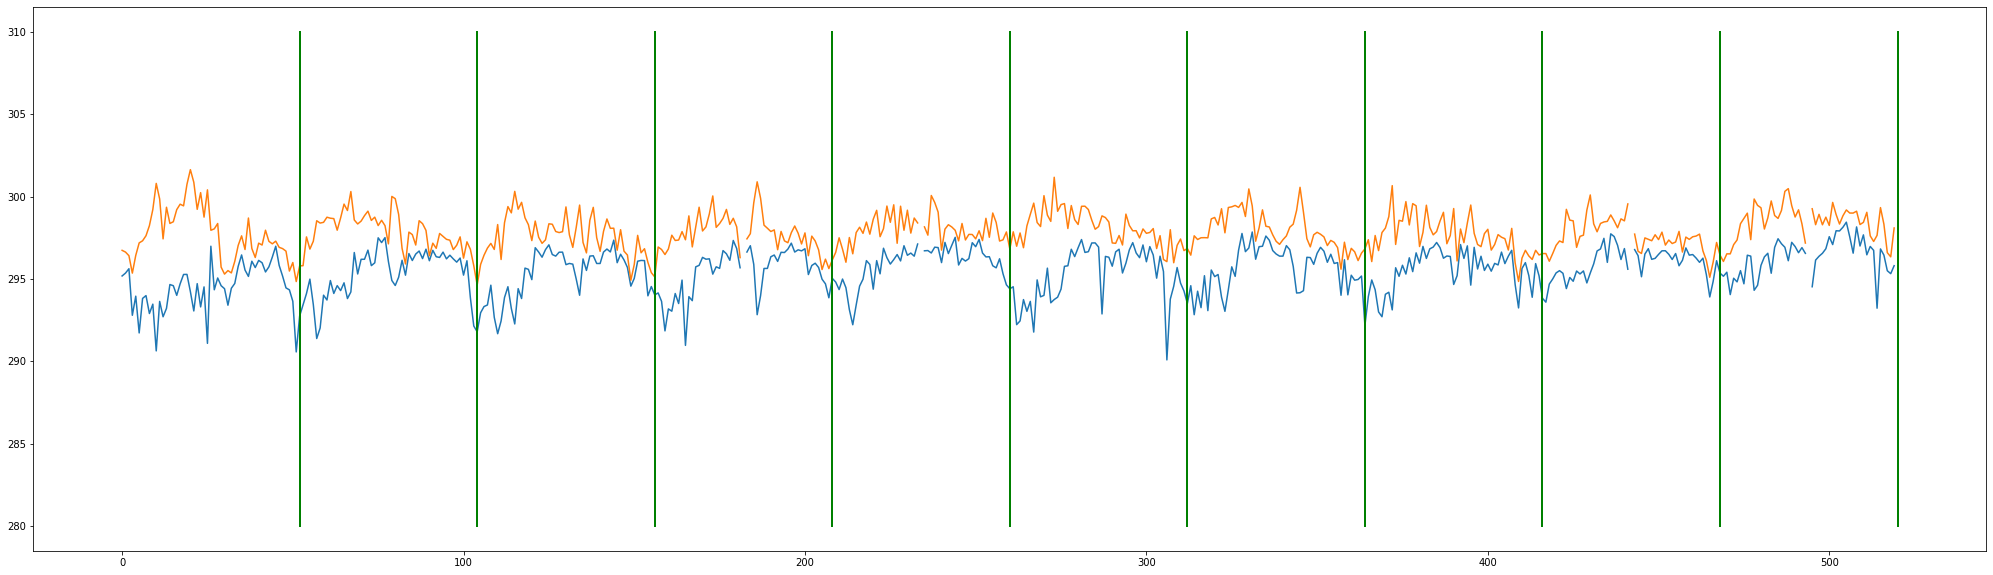

In [ ]:
plt.figure(figsize=(35, 10))
plt.plot(range(len(iq_train["week_start_date"])), iq_train["reanalysis_dew_point_temp_k"])
plt.plot(range(len(iq_train["week_start_date"])), iq_train["reanalysis_air_temp_k"])
plt.plot([52, 52, 52], [280, 295, 310],color='green',linewidth=2)
plt.plot([104, 104, 104], [280, 295, 310],color='green',linewidth=2)
plt.plot([156, 156, 156], [280, 295, 310],color='green',linewidth=2)
plt.plot([208, 208, 208], [280, 295, 310],color='green',linewidth=2)
plt.plot([260, 260, 260], [280, 295, 310],color='green',linewidth=2)
plt.plot([312, 312, 312], [280, 295, 310],color='green',linewidth=2)
plt.plot([52*7, 52*7, 52*7], [280, 295, 310],color='green',linewidth=2)
plt.plot([52*8, 52*8, 52*8], [280, 295, 310],color='green',linewidth=2)
plt.plot([52*9, 52*9, 52*9], [280, 295, 310],color='green',linewidth=2)
plt.plot([52*10, 52*10, 52*10], [280, 295, 310],color='green',linewidth=2)

plt.show()

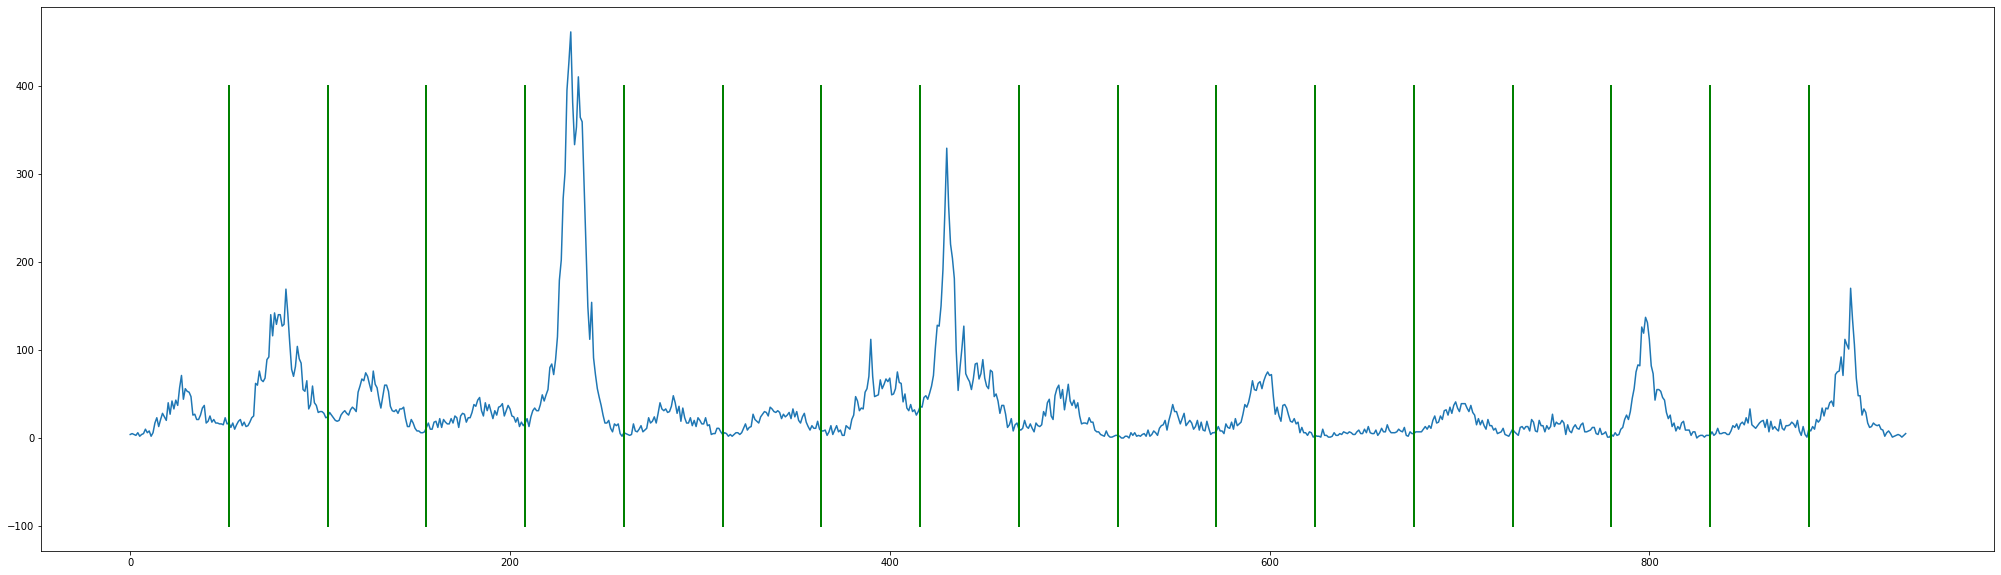

In [ ]:
plt.figure(figsize=(35, 10))
plt.plot(range(len(sj_train["week_start_date"])), sj_train["total_cases"])
plt.plot([52, 52, 52], [-100, 200, 400],color='green',linewidth=2)
plt.plot([104, 104, 104], [-100, 200, 400],color='green',linewidth=2)
plt.plot([156, 156, 156], [-100, 200, 400],color='green',linewidth=2)
plt.plot([208, 208, 208], [-100, 200, 400],color='green',linewidth=2)
plt.plot([260, 260, 260], [-100, 200, 400],color='green',linewidth=2)
plt.plot([312, 312, 312], [-100, 200, 400],color='green',linewidth=2)
plt.plot([52*7, 52*7, 52*7], [-100, 200, 400],color='green',linewidth=2)
plt.plot([52*8, 52*8, 52*8], [-100, 200, 400],color='green',linewidth=2)
plt.plot([52*9, 52*9, 52*9], [-100, 200, 400],color='green',linewidth=2)
plt.plot([52*10, 52*10, 52*10], [-100, 200, 400],color='green',linewidth=2)
plt.plot([52*11, 52*11, 52*11], [-100, 200, 400],color='green',linewidth=2)
plt.plot([52*12, 52*12, 52*12], [-100, 200, 400],color='green',linewidth=2)
plt.plot([52*13, 52*13, 52*13], [-100, 200, 400],color='green',linewidth=2)
plt.plot([52*14, 52*14, 52*14], [-100, 200, 400],color='green',linewidth=2)
plt.plot([52*15, 52*15, 52*15], [-100, 200, 400],color='green',linewidth=2)
plt.plot([52*16, 52*16, 52*16], [-100, 200, 400],color='green',linewidth=2)
plt.plot([52*17, 52*17, 52*17], [-100, 200, 400],color='green',linewidth=2)
plt.show()

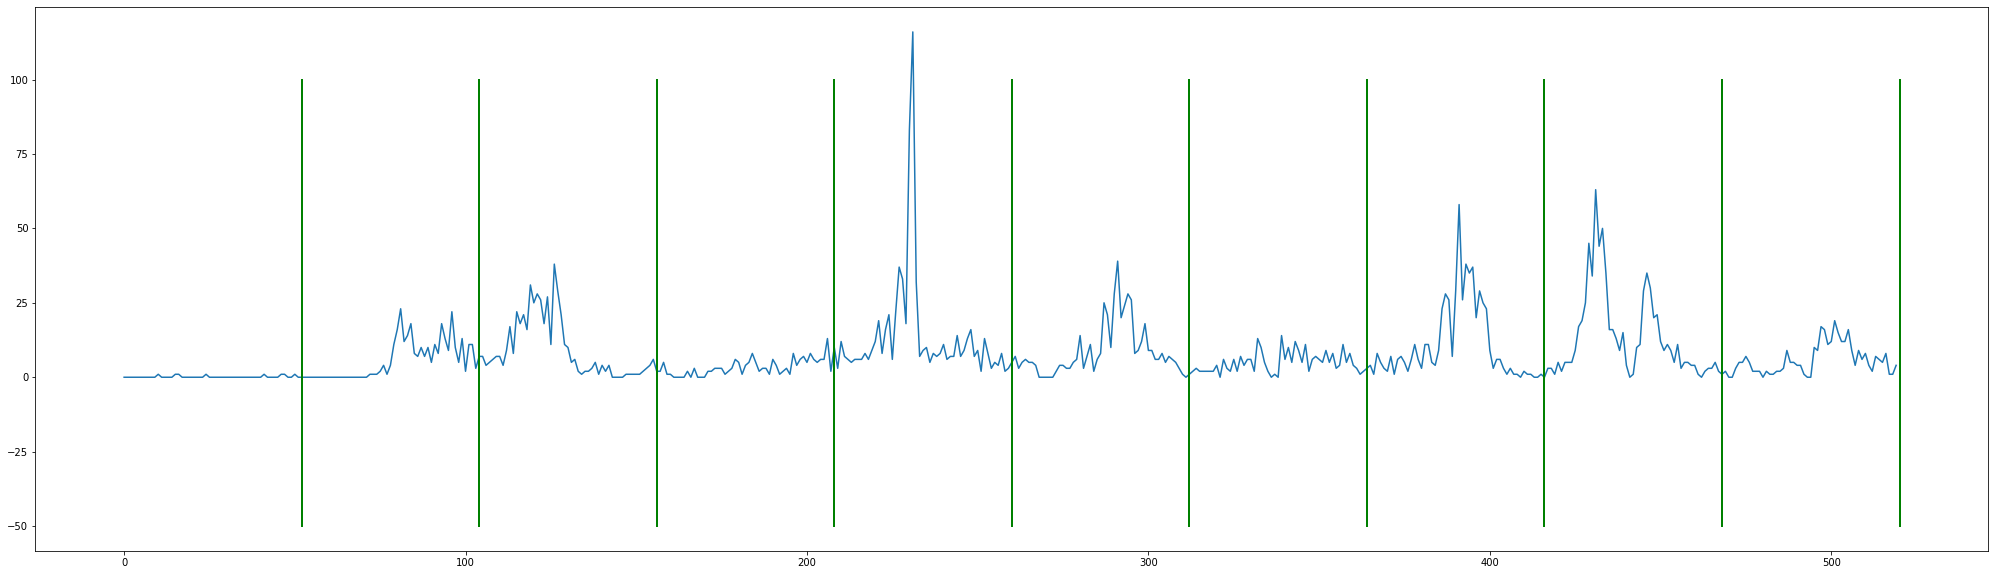

In [ ]:
plt.figure(figsize=(35, 10))
plt.plot(range(len(iq_train["week_start_date"])), iq_train["total_cases"])
plt.plot([52, 52, 52], [-50, 50, 100],color='green',linewidth=2)
plt.plot([104, 104, 104], [-50, 50, 100],color='green',linewidth=2)
plt.plot([156, 156, 156], [-50, 50, 100],color='green',linewidth=2)
plt.plot([208, 208, 208], [-50, 50, 100],color='green',linewidth=2)
plt.plot([260, 260, 260], [-50, 50, 100],color='green',linewidth=2)
plt.plot([312, 312, 312], [-50, 50, 100],color='green',linewidth=2)
plt.plot([52*7, 52*7, 52*7], [-50, 50, 100],color='green',linewidth=2)
plt.plot([52*8, 52*8, 52*8], [-50, 50, 100],color='green',linewidth=2)
plt.plot([52*9, 52*9, 52*9], [-50, 50, 100],color='green',linewidth=2)
plt.plot([52*10, 52*10, 52*10], [-50, 50, 100],color='green',linewidth=2)
plt.show()

In [ ]:
my_order = (1, 0, 1)
my_seasonal_order = (1, 1, 1, 52)

In [ ]:
sj_sarima_model = SARIMAX(sj_train["total_cases"], order=my_order, seasonal_order=my_seasonal_order)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
sj_sarima_model_fit = sj_sarima_model.fit()

In [ ]:
sj_preds = sj_sarima_model_fit.predict(start=len(sj_train), end=len(sj_train)+len(sj_test)-1, dynamic=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [ ]:
sj_preds = round(sj_preds).astype(int)

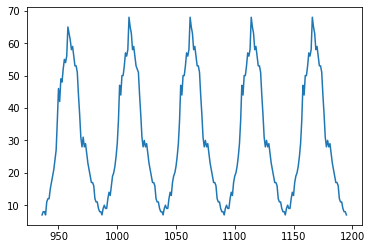

In [ ]:
plt.plot(sj_preds)
plt.show()

In [ ]:
iq_sarima_model = SARIMAX(iq_train["total_cases"], order=my_order, seasonal_order=my_seasonal_order)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
iq_sarima_model_fit = iq_sarima_model.fit()

In [ ]:
iq_preds = iq_sarima_model_fit.predict(start=len(iq_train), end=len(iq_train)+len(iq_test)-1, dynamic=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [ ]:
iq_preds = round(iq_preds).astype(int)

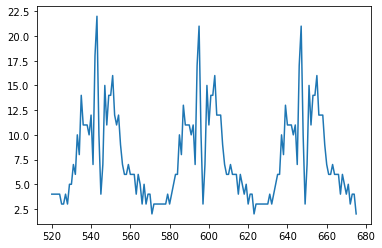

In [ ]:
plt.plot(iq_preds)
plt.show()

In [ ]:
total_preds = sj_preds.append(iq_preds)

In [ ]:
total_preds.index = range(len(sj_test) + len(iq_test))

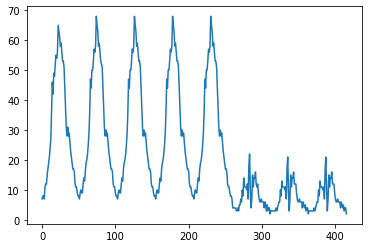

In [ ]:
plt.plot(total_preds)

In [ ]:
submission["total_cases"] = total_preds

In [ ]:
submission

,city,year,weekofyear,total_cases
0,sj,2008,18,7
1,sj,2008,19,8
2,sj,2008,20,8
3,sj,2008,21,7
4,sj,2008,22,11
...,...,...,...,...
411,iq,2013,22,5
412,iq,2013,23,3
413,iq,2013,24,4
414,iq,2013,25,4


In [ ]:
#submission.to_csv("submission_sarima_ar1_ma1_si1.csv", index=False)